## Vectorizing

Remember that if len_signals == strats, then broadcasting can be broken.

I think currently the justification is that we need to have performance over code readability. Vectorising the logic is key.

Change wealth -> cash makes way more sense

## Next up
- Params and analytics for agent behaviour

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from market import *
# plt.style.use('ggplot')
plt.style.use('dark_background')
%load_ext autoreload
%autoreload 2

In [2]:
import time
s = time.time()

m = Market(len_agents=1000,action_ratio=0.05,strats_per_agent=75)

# m.simulate_k_step()

print(time.time() - s) #6.5 min for 2000 iterations with 200 agents

sellers = np.unique([item for sublist in m.sell_history[m.k:] for item in sublist])
buyers = np.unique([item for sublist in m.buy_history[m.k:] for item in sublist])

a = np.sum((m.actions<0)*m.strat_strengths)
b = np.sum((m.actions>0)*m.strat_strengths)
print(f'sell_str_sum={np.sum(a)}; buy_str_sum={np.sum(b)}')

2.4911158084869385
sell_str_sum=3751.099999999999; buy_str_sum=3748.8999999999996


In [3]:
m.simulate_k_step(100)

# (m.strat_strengths.min()),(m.strat_strengths.max())

# np.sum(np.sum(np.sum(np.abs(np.array(m.strat_history[:100])),axis=3),axis=2),axis=1)[[0,-1]]

In [530]:
i,a = m._get_activated_strats().T
print(np.unique(m.actions[i,a],return_counts=True))

len(m.buy_history[-1]), len(m.sell_history[-1])

(array([-1,  1]), array([638, 689]))


(143, 160)

In [531]:
np.unique(m._get_agent_actions()[1],return_counts=True)

(array([-1,  1]), array([164, 139]))

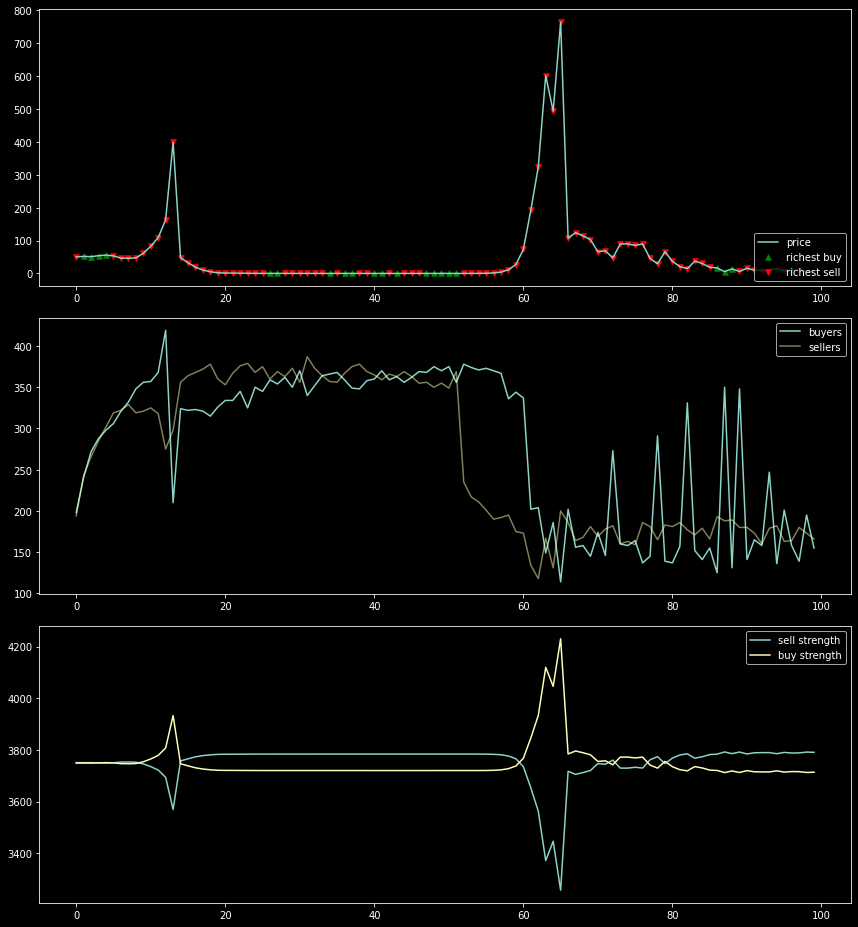

In [5]:
###
df = pd.DataFrame(
    np.array([m.agents_cash,m.agents_stock]).T,
    columns= ['cash','stock']
)
df['wealth'] = df.cash + m.price * df.stock
richest = df.wealth.argmax()
when_buy = np.arange(len(m.price_history)-m.k)[lmap(lambda l: richest in l, m.buy_history[m.k:])]
when_sell = np.arange(len(m.price_history)-m.k)[lmap(lambda l: richest in l, m.sell_history[m.k:])]
###

m.k = 7
timesteps = len(m.buy_history) #

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,13))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

# a = axes[0]
axes[0].plot(m.price_history[m.k:timesteps],label = 'price') #-', '--', '-.', ':', ''
axes[0].scatter(when_buy[:timesteps], np.array(m.price_history[m.k:timesteps])[when_buy],s=30,c='green',marker="^",label = 'richest buy')
axes[0].scatter(when_sell[:timesteps], np.array(m.price_history[m.k:timesteps])[when_sell],s=30,c='red',marker="v",label = 'richest sell')
axes[1].plot(lmap(len, m.buy_history[m.k:timesteps]),label = 'buyers')
axes[1].plot(lmap(len, m.sell_history[m.k:timesteps]),label = 'sellers',alpha=0.5)
# axes[1].plot(m.volume_history[m.k:],'--',label = 'vol')
axes[2].plot(m.sell_str_sum_history[:timesteps],label = 'sell strength')
axes[2].plot(m.buy_str_sum_history[:timesteps],label = 'buy strength')
axes[0].legend(loc='lower right')
axes[1].legend(loc='best')
axes[2].legend(loc='best')
plt.show()

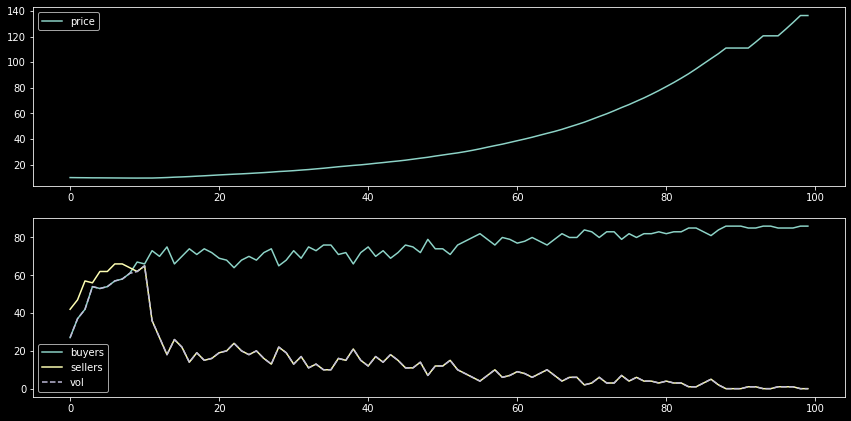

In [297]:
# m.simulate_k_step()
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(12,6))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

# a = axes[0]
axes[0].plot(m.price_history[m.k:],label = 'price')
axes[1].plot(lmap(len, m.buy_history[m.k:]),label = 'buyers')
axes[1].plot(lmap(len, m.sell_history[m.k:]),label = 'sellers')
axes[1].plot(m.volume_history[m.k:],'--',label = 'vol')
axes[0].legend(loc='best')
axes[1].legend(loc='best')
plt.show()

In [195]:
np.unique(m._get_agent_actions()[1],return_counts=True)

(array([-1,  1]), array([17, 74]))

## Signal vectorisation

In [8]:
"""[i,j] has info on means[j] > linspace[i] * price"""
np.greater(np.vstack([means]*k), (np.linspace(0.5,1.3,k)*m.price)[:,None])

NameError: name 'means' is not defined

In [19]:
m._get_activated_strats().shape

(0, 2)

In [21]:
from market import *

In [22]:
m = Market(len_agents=1000)

In [23]:
total_refresh, total_transact, total_feedback, total_update_market = 0,0,0,0
total_mutate = 0
for _ in range(50):
    """Note that order TBD"""
    start = time.time()
    m._refresh_params() #sets last price
    total_refresh += time.time() - start
    start = time.time()
    m._transact() #sets new price
    total_transact += time.time() - start
    start = time.time()
    m._feedback_strats()
    total_feedback += time.time() - start
    start = time.time()
    m._update_market_state()
    total_update_market += time.time() - start
    start = time.time()
    m._mutate_strats()
    total_mutate += time.time() - start

In [24]:
a = np.array([total_refresh, total_transact, total_feedback, total_update_market, total_mutate])
s = a.sum()
np.round(a/s,3)

array([0.886, 0.   , 0.095, 0.001, 0.018])

In [25]:
s

63.37509226799011